In [1]:
import carball
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import requests
%matplotlib inline

In [57]:
def get_game_hashes():
    r = requests.get("https://calculated.gg/api/v1/replays?key=1&minrank=19&playlist=13&year=2019&num=100").json()['data']
    return [g['hash'] for g in r]

def get_games():
    games = []
    hashes = get_game_hashes()
    for hash_ in hashes:
        r = requests.get("https://calculated.gg/api/v1/replay/{}?key=1".format(hash_))
        games.append(r.json())
    return games

def get_match_history(id_):
    r = requests.get("https://calculated.gg/api/replay?page=0&limit=1&player_ids={}&playlists=13".format(id_))
    return r.json()

def get_replay_count(id_):
    r = get_match_history(id_)
    return r['totalCount']

def get_player_stats(id_: str):
    r = requests.get("https://calculated.gg/api/player/{}/play_style/all".format(id_))
    return r.json()['dataPoints']

In [58]:
player_count_map = {}
player_stat_map = {}

In [60]:
data = []
games = get_games()
for game in games:
    skip_game = False
    metadata = game['gameMetadata']
    winner = 0
    print(game.keys())
    if metadata['score']['team0Score'] > metadata['score']['team1Score']:
        winner = 0
    elif metadata['score']['team0Score'] < metadata['score']['team1Score']:
        winner = 1
    else:
        continue # tied
    blue_dfs = []
    orange_dfs = []
    for player in game['players']:
        p = player['id']['id']
        if p in player_count_map:
            count = player_count_map[p]
        else:
            count = get_replay_count(p)
            player_count_map[p] = count
        
        if count < 10:
            skip_game = True
            break
        if p in player_stat_map:
            stats = player_stat_map[p]
        else:
            try:
                stats = get_player_stats(p)
            except:
                skip_game = True
                break
            player_stat_map[p] = stats
        statdf = pd.DataFrame(stats).set_index("name")
        if player['isOrange'] == 0:
            blue_dfs.append(statdf)
        elif player['isOrange'] == 1:
            orange_dfs.append(statdf)
    if skip_game:
        continue
    
    data.append({
        "blue0": blue_dfs[0],
        "blue1": blue_dfs[1],
        "blue2": blue_dfs[2],
        "orange0": orange_dfs[0],
        "orange1": orange_dfs[2],
        "orange2": orange_dfs[2],
        "result": winner
    })

dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', '

dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'gameStats', 'parties', 'version', 'mutators'])
dict_keys(['gameMetadata', 'players', 'teams', 'ga

In [61]:
data[0]['blue0'].T.head()

name,score,goals,assists,saves,shots,boost usage,num small boosts,num large boosts,wasted collection,wasted usage,...,passes/hit,assists/hit,useful/hits,shot %,collection boost efficiency,used boost efficiency,total boost efficiency,turnover efficiency,boost ratio,aerial efficiency
average,405.05928,0.909967,0.744518,1.654485,2.771262,2287.974075,68.702488,22.252823,779.901152,296.507287,...,30.375,2.791667,44.708333,0.328358,0.756562,0.876937,0.664003,75.25,2.625,28.170812


In [65]:
import itertools

[(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]

In [73]:
def process_data(dat):
    overall_dfs = []
    for game in dat:
        for perm in itertools.permutations(range(3)):
            dfs  = []
            for l, i in enumerate(perm):
                selected = game['blue'+str(i)].T
                dfs.append(selected.rename(columns={c: 'b'+str(l)+c for c in selected.columns}))
            for perm2 in itertools.permutations(range(3)):
                dfs2 = []
                for l, i in enumerate(perm2):
                    selected = game['orange'+str(i)].T
                    dfs2.append(selected.rename(columns={c: 'o'+str(l)+c for c in selected.columns}))
                df = pd.concat(dfs + dfs2, axis=1)
                df['result'] = game['result']
                overall_dfs.append(df)
    return pd.concat(overall_dfs)

array([0.53584171])

In [75]:
df = process_data(data)

In [86]:
input = df.drop("result", axis=1)
output = df["result"]

In [87]:
threshold = np.random.rand(len(df)) < 0.9
train_input, train_output = input[threshold].values, output[threshold].values
test_input, test_output = input[~threshold].values, output[~threshold].values

In [105]:
num_columns = len(input.columns)
n_hidden = 128
class ResultPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(num_columns, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden//2),
            nn.ReLU(),
            nn.Linear(n_hidden//2, 1),
            nn.Sigmoid()
        )
    
    def forward(self, game_state):
        game_state = torch.from_numpy(game_state).float().cuda()
        return self.layers(game_state)

In [111]:
model = ResultPredictor().cuda().train()
opt = optim.Adam(model.parameters(), lr=1e-2)
loss = nn.MSELoss()
epochs = int(10000)
epoch_losses = []
accuracy = []


output_tensor = torch.from_numpy(train_output).float().cuda()

for epoch in range(epochs):
    opt.zero_grad()
    predicted = model(train_input)
    loss_val = loss(predicted, output_tensor)
    loss_val.backward()
    opt.step()
    
    predicted = model(test_input)
    predicted = predicted.cpu().detach().numpy().astype(float)
#     print(predicted.shape, output_test.shape)
#     assert(predicted.shape == output_test.shape)#, "{}, {}".format(predicted.shape, output_test.shape))
    acc = ((predicted.T.astype(float) > 0.5) == (test_output == 1)).sum() / predicted.shape[0]
    epoch_losses.append(loss_val.cpu().data.numpy())
    accuracy.append(acc)

In [112]:
predicted.sum() / predicted.shape[0]

1.0

In [113]:
(predicted.astype(float) > 0.5)

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [

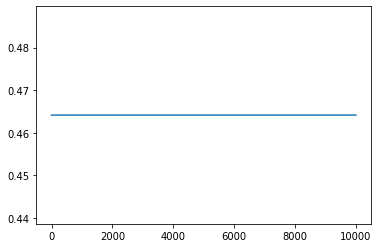

In [114]:
plt.plot(range(len(epoch_losses)), epoch_losses);

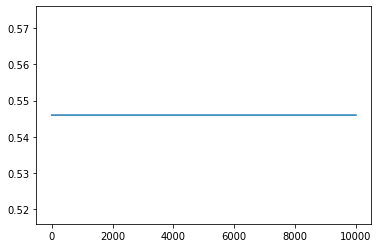

In [115]:
plt.plot(range(len(accuracy)), accuracy);